## 1.0 Data loading and exploration

1.1 Importing necesary libraries

In [ ]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from xgboost import XGBClassifier

1.2 Import Alzheimer csv

In [ ]:
df = pd.read_csv('alzheimer.csv')

1.3 Data Exploration

In [ ]:
df.head()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [ ]:
#show the dimention of the data (row, columns)
df.shape

(373, 10)

In [ ]:
#Display the columns
df.columns

Index(['Group', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV',
       'ASF'],
      dtype='object')

In [ ]:
#display the data type
df.dtypes

Group     object
M/F       object
Age        int64
EDUC       int64
SES      float64
MMSE     float64
CDR      float64
eTIV       int64
nWBV     float64
ASF      float64
dtype: object

In [ ]:
#display descriptive statistics of the numerical columns
df.describe()

,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


## 2.0 Expolarty analysis


**2.1 Checking for missing values**

In [ ]:
# Check for missing values
missing_values = df.isnull()

# Count missing values in each column
missing_count = missing_values.sum()

missing_count

Group     0
M/F       0
Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

There is two missing data in SES and MMSE

**2.2 Checking for outliers**

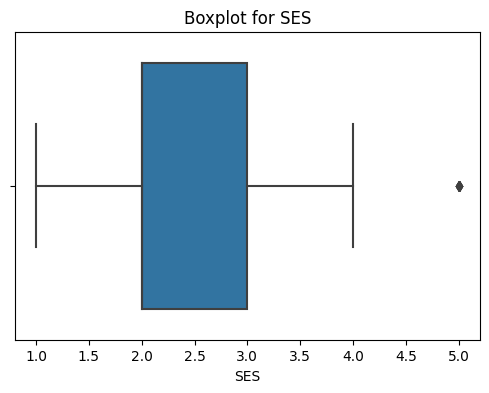

Number of outliers in 'SES': 7


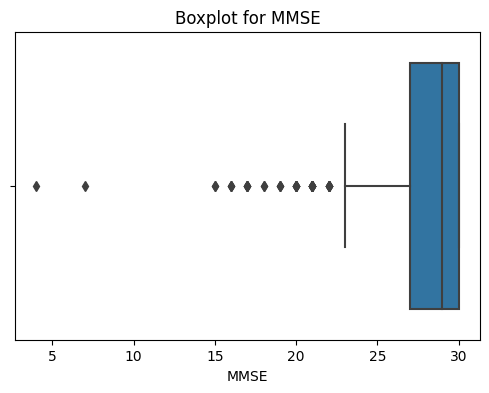

Number of outliers in 'MMSE': 42


In [ ]:
columns_to_check = ['SES', 'MMSE']

for column in columns_to_check:
    plt.figure(figsize=(6, 4))

    # Boxplot
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot for {column}')
    plt.show()

    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)

    # Count the number of outliers
    num_outliers = outliers.sum()

    print(f"Number of outliers in '{column}': {num_outliers}")


**2.3 Checking the distribution of missing values**

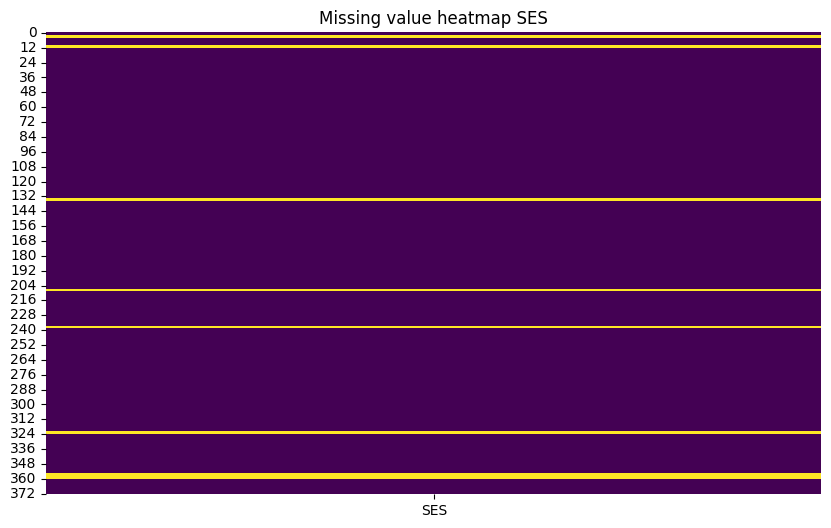

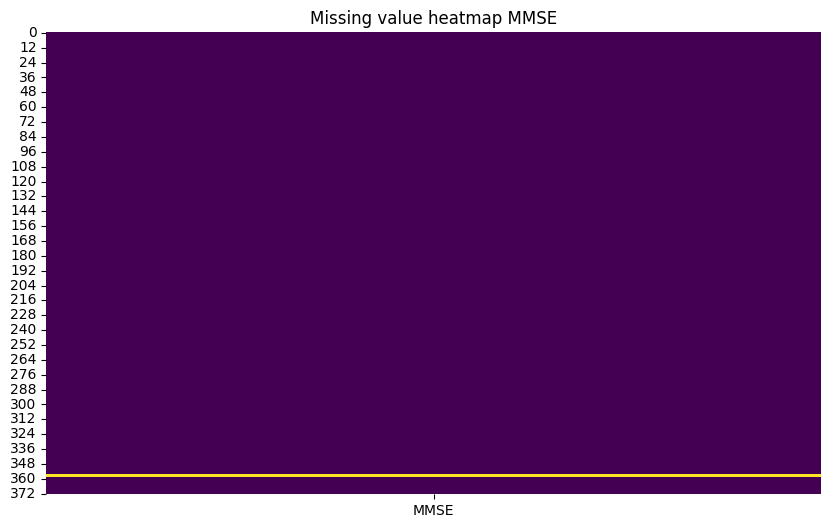

In [ ]:
columns_to_check = ['SES', 'MMSE']

for column in columns_to_check:
  plt.figure(figsize=(10, 6))
  sns.heatmap(df[[column]].isnull(), cbar=False, cmap='viridis')
  plt.title(f"Missing value heatmap {column}")
  plt.show()

The missing values seem to be missing at random (MAR)

**2.4 Mean imputation**

Mean imputation is a method used to handle missing data in a dataset by replacing the missing values with the mean of the observed values for that particular variable.

the mean imputation formula for each missing value X(missing) is given by:


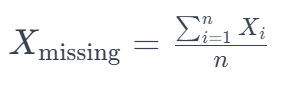

In [ ]:
columns_to_impute = ['SES', 'MMSE']

# Perform mean imputation
for column in columns_to_impute:
    # Calculate the mean of the non-missing values in the column
    mean_value = df[column].mean()

    # Replace missing values with the mean
    df[column].fillna(mean_value, inplace=True)

# Display the DataFrame after mean imputation
df.isnull().sum()

Group    0
M/F      0
Age      0
EDUC     0
SES      0
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

**2.5 Univariate Analysis**

Univariate analysis involves examining the distribution and characteristics of a single variable.

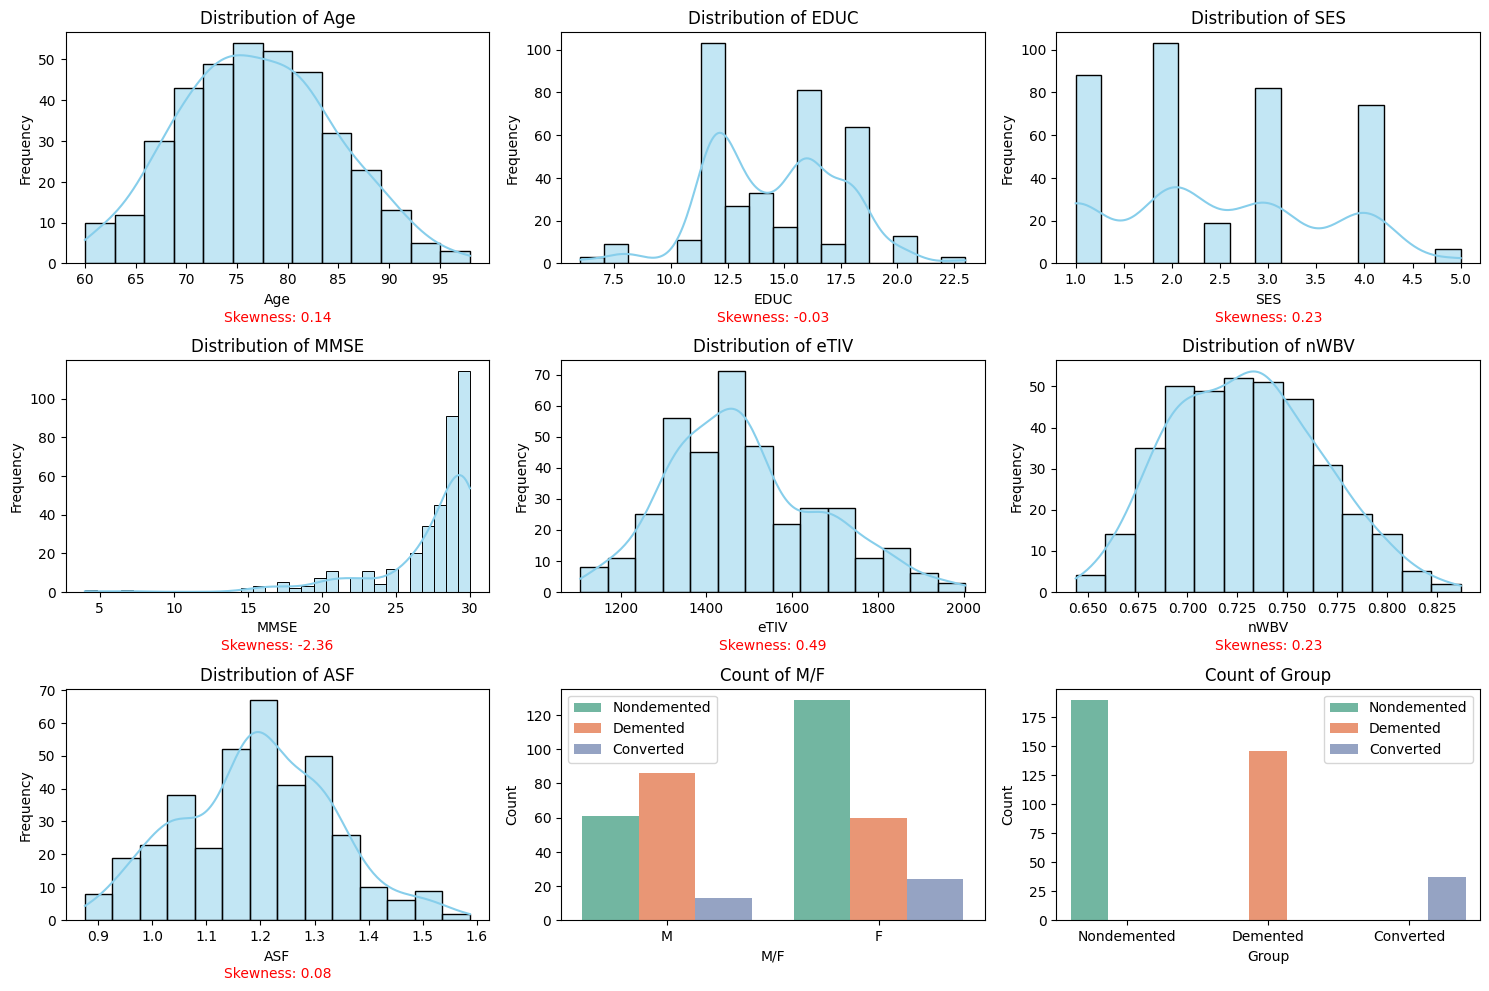

In [ ]:
from scipy.stats import skew, probplot

# Set up the figure size
plt.figure(figsize=(15, 10))

# Univariate Analysis for Numeric Features
numeric_features = ['Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Calculate skewness
    skewness_value = skew(df[feature])

    # Annotate the subplot with skewness information below the plot
    plt.annotate(f'Skewness: {skewness_value:.2f}', xy=(0.5, -0.25), xycoords='axes fraction', ha='center', fontsize=10, color='red')


# Univariate Analysis for Categorical Features
categorical_features = ['M/F', 'Group']

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i + 7)  # Adjust subplot position for categorical features
    sns.countplot(data=df, x=feature, hue='Group', palette='Set2')
    plt.title(f'Count of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

Notes:


**2.6 Bivariate Analysis**

exploring the relationship between two variables. In this case, comparing different numeric features across groups ('Nondemented', 'Demented', 'Converted') and exploring the relationship between categorical features and the 'Group' variable.

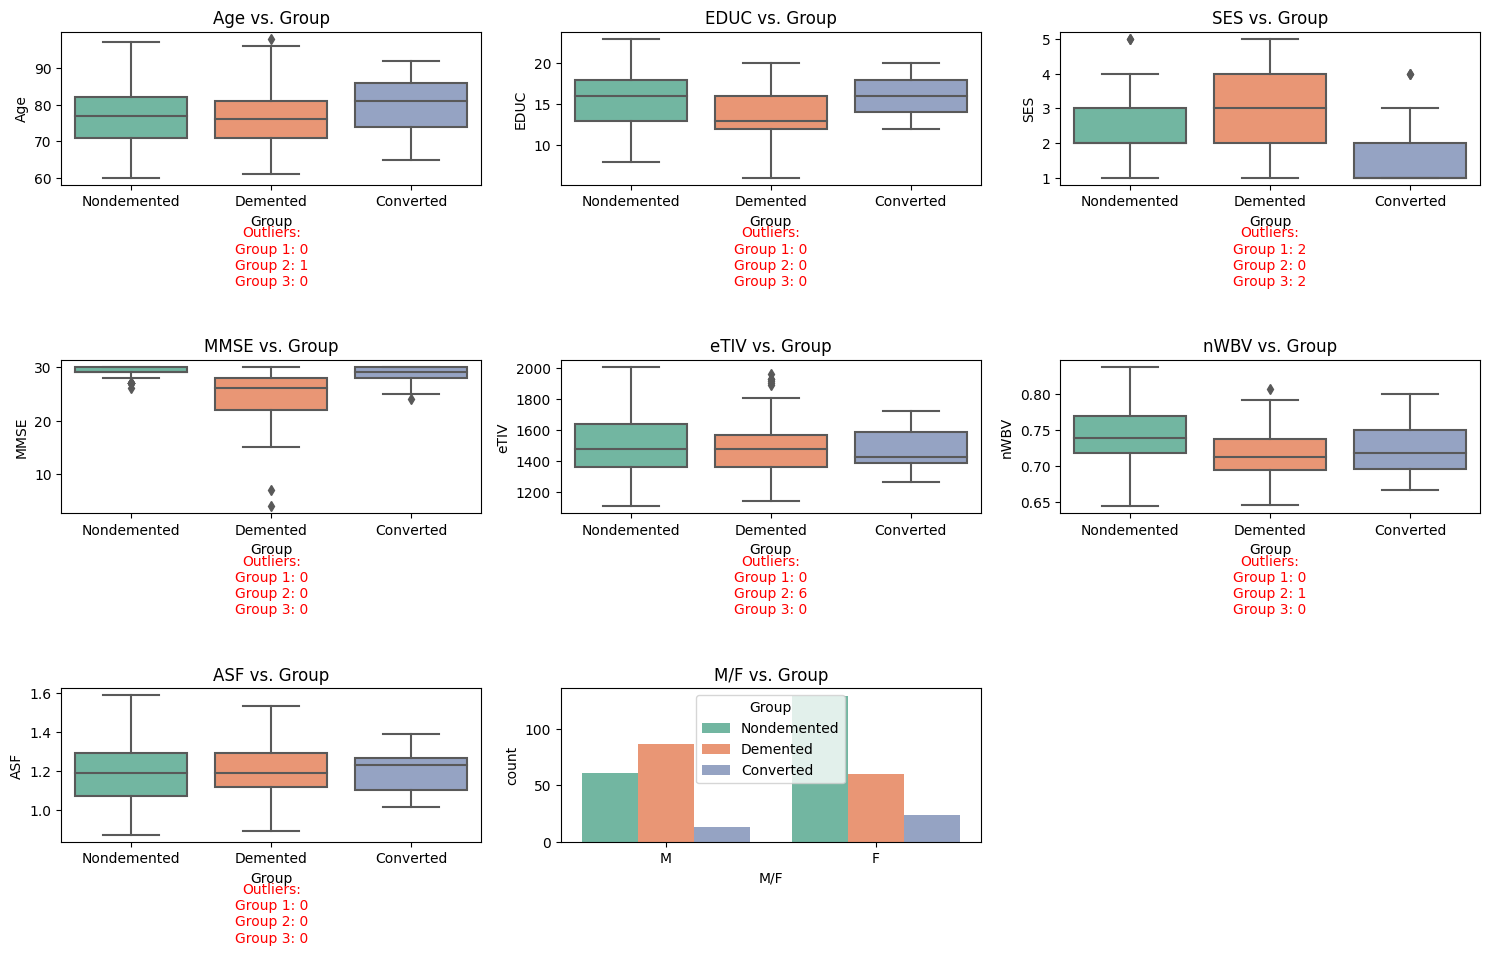

In [ ]:
# Set up the figure size
plt.figure(figsize=(15, 10))

# Bivariate Analysis for Numeric Features
numeric_features = ['Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Group', y=feature, data=df, palette='Set2')  # Change palette to 'Set2'
    plt.title(f'{feature} vs. Group')

    # Calculate the upper bounds for each group
    upper_bound_group1 = df[df['Group'] == 'Nondemented'][feature].quantile(0.75) + 1.5 * (
        df[df['Group'] == 'Nondemented'][feature].quantile(0.75) - df[df['Group'] == 'Nondemented'][feature].quantile(0.25))

    upper_bound_group2 = df[df['Group'] == 'Demented'][feature].quantile(0.75) + 1.5 * (
        df[df['Group'] == 'Demented'][feature].quantile(0.75) - df[df['Group'] == 'Demented'][feature].quantile(0.25))

    upper_bound_group3 = df[df['Group'] == 'Converted'][feature].quantile(0.75) + 1.5 * (
        df[df['Group'] == 'Converted'][feature].quantile(0.75) - df[df['Group'] == 'Converted'][feature].quantile(0.25))

    # Calculate the number of outliers for each group
    outliers_group1 = sum((df['Group'] == 'Nondemented') & (df[feature] > upper_bound_group1))
    outliers_group2 = sum((df['Group'] == 'Demented') & (df[feature] > upper_bound_group2))
    outliers_group3 = sum((df['Group'] == 'Converted') & (df[feature] > upper_bound_group3))

    # Annotate the subplot with the number of outliers
    plt.text(0.5, -0.47, f'Outliers:\nGroup 1: {outliers_group1}\nGroup 2: {outliers_group2}\nGroup 3: {outliers_group3}',
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, color='red')

# Bivariate Analysis for Categorical Features
categorical_features = ['M/F']

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i + 7)  # Adjust subplot position for categorical features
    sns.countplot(x=feature, hue='Group', data=df, palette='Set2')
    plt.title(f'{feature} vs. Group')

plt.tight_layout()
plt.show()

Notes:

**2.7 interactive scatter plot**

In [ ]:
import plotly.express as px
import pandas as pd


fig = px.scatter(df, x='Age', y='MMSE', color='Group', title='Interactive Scatter Plot',
                 labels={'Age': 'Age', 'MMSE': 'MMSE'}, hover_data=['Age', 'MMSE', 'EDUC', 'SES'],
                 color_discrete_sequence=px.colors.qualitative.Set2)

# Show the interactive plot
fig.show()


## 3.0 Data Cleaning

**3.1 Handling Outliers**

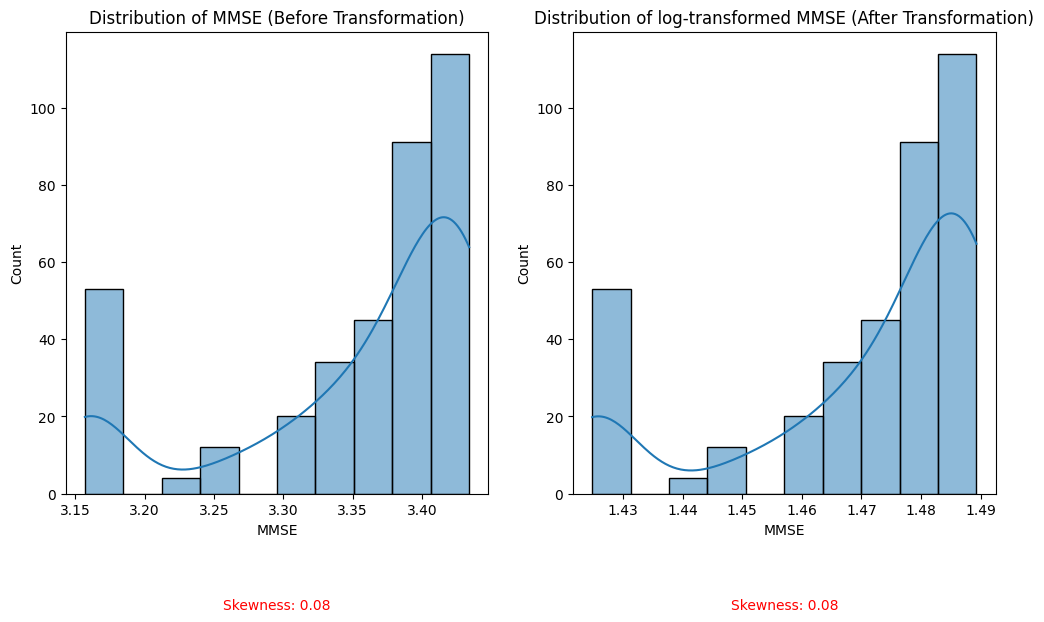

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Outlier treatment using IQR for numeric features
numeric_features = ['Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

for feature in numeric_features:
    # Calculate quartiles and IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    df[feature] = np.clip(df[feature], lower_bound, upper_bound)

# Apply logarithmic transformation to 'MMSE'
df['MMSE'] = np.log1p(df['MMSE'])

# Visualize the distribution of 'MMSE' before and after transformation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['MMSE'], kde=True)
plt.title('Distribution of MMSE (Before Transformation)')
plt.annotate(f'Skewness: {skewness_value:.2f}', xy=(0.5, -0.25), xycoords='axes fraction', ha='center', fontsize=10, color='red')#fix

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['MMSE']), kde=True)
plt.title('Distribution of log-transformed MMSE (After Transformation)')
plt.annotate(f'Skewness: {skewness_value:.2f}', xy=(0.5, -0.25), xycoords='axes fraction', ha='center', fontsize=10, color='red')#fix
plt.show()

**3.2.0 Label Encoding**

> **3.2.1 'Group' label encoding**



In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Group'] = le.fit_transform(df['Group'])

 >  **3.2.2 One-hot encoding for M/F rows**



In [ ]:
df = pd.get_dummies(df, columns=['M/F'], drop_first=True)

**3.3 Checcking and handling duplicates**

In [ ]:
# Check for duplicate rows based on all columns
duplicates = df.duplicated()

# Display rows with duplicates, if any
print("Duplicate Rows:")
print(df[duplicates])

# Display DataFrame after removing duplicates
print("\nDataFrame after Removing Duplicates:")
df_no_duplicates = df.drop_duplicates()
print(df_no_duplicates)

Duplicate Rows:
Empty DataFrame
Columns: [Group, Age, EDUC, SES, MMSE, CDR, eTIV, nWBV, ASF, M/F_M]
Index: []

DataFrame after Removing Duplicates:
     Group  Age  EDUC       SES      MMSE  CDR  eTIV   nWBV    ASF  M/F_M
0        2   87    14  2.000000  3.332205  0.0  1957  0.696  0.883      1
1        2   88    14  2.000000  3.433987  0.0  1957  0.681  0.876      1
2        1   75    12  2.460452  3.178054  0.5  1678  0.736  1.046      1
3        1   76    12  2.460452  3.367296  0.5  1738  0.713  1.010      1
4        1   80    12  2.460452  3.157000  0.5  1698  0.701  1.034      1
..     ...  ...   ...       ...       ...  ...   ...    ...    ...    ...
368      1   82    16  1.000000  3.367296  0.5  1693  0.694  1.037      1
369      1   86    16  1.000000  3.295837  0.5  1688  0.675  1.040      1
370      2   61    13  2.000000  3.433987  0.0  1319  0.801  1.331      0
371      2   63    13  2.000000  3.433987  0.0  1327  0.796  1.323      0
372      2   65    13  2.000000  3.433

There is no duplicates

**3.4.0 Creating new features**

> **3.4.1 'SES' and 'EDUC' Factor**



> Create a new feature the join the relationship of SES (socioeconomic status) and EDUC (education)



In [ ]:
# Create an interaction term
df['SES_EDUC_interaction'] = df['SES'] * df['EDUC']

> **3.4.2 Brain volume ratio**



In [ ]:
# Create a brain volume ratio
df['Brain_Volume_Ratio'] = df['nWBV'] / df['eTIV']

> **3.4.3Age x MMSE Interaction**



In [ ]:
# Create an interaction term
df['Age_MMSE_interaction'] = df['Age'] * df['MMSE']

**3.5 Sample data aftre the modifications**

In [ ]:
df.sample(10)

,Group,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,M/F_M,SES_EDUC_interaction,Brain_Volume_Ratio,Age_MMSE_interaction
325,2,79,16,1.000000,3.433987,0.0,1817,0.736,0.966,1,16.000000,0.000405,271.284989
166,2,69,16,2.000000,3.367296,0.0,1848,0.737,0.950,1,32.000000,0.000399,232.343412
321,1,76,14,3.000000,3.367296,0.5,1236,0.764,1.419,0,42.000000,0.000618,255.914483
198,2,71,18,1.000000,3.433987,0.0,1769,0.699,0.992,1,18.000000,0.000395,243.813092
278,2,78,18,2.000000,3.332205,0.0,1645,0.663,1.067,1,36.000000,0.000403,259.911952
36,0,80,20,1.000000,3.401197,0.0,1587,0.693,1.106,1,20.000000,0.000437,272.095791
356,1,74,12,2.460452,3.295837,0.5,1171,0.733,1.499,0,29.525424,0.000626,243.891928
83,0,75,16,1.000000,3.367296,0.5,1314,0.760,1.335,0,16.000000,0.000578,252.547187
319,2,76,15,4.000000,3.401197,0.0,1281,0.680,1.370,0,60.000000,0.000531,258.491001
271,0,65,12,2.000000,3.433987,0.5,1340,0.754,1.309,0,24.000000,0.000563,223.209168


**3.6 Downloading the new modified dataframe**

In [ ]:
df.columns

Index(['Group', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF',
       'M/F_M', 'SES_EDUC_interaction', 'Brain_Volume_Ratio',
       'Age_MMSE_interaction'],
      dtype='object')

## 4.0 Machine learning models

**4.1.0 Pre-training**

> **4.1.1 Splitting the data**



In [ ]:
from sklearn.model_selection import train_test_split
# X a variable which includes all the independent variables used for prediction.
#y represents the target variable or the dependent variable that you want to predict.
X = df.drop(['Group'], axis=1)
y = df['Group']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



> **4.1.2 Standarizing the data**



In [ ]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are your feature matrices
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



> **4.1.3 Synthetic Minority Over-sampling Technique (SMOTE)**

 SMOTE: is an oversampling technique that generates synthetic samples for the minority class by interpolating between existing samples. It helps balance the class distribution. Only used for the training set.



In [ ]:
from imblearn.over_sampling import SMOTE

# Create an instance of the SMOTE class
oversampler = SMOTE(random_state=42)

# Apply SMOTE to your data
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_scaled, y_train)



> **4.1.4 Principal Component Analysis (PCA)**

PCA: is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional representation while retaining as much of the original variance as possible.



In [ ]:
from sklearn.decomposition import PCA

# Create an instance of the PCA class with the desired number of components (8 in this case)
pca = PCA(n_components=8)

# Fit and transform the oversampled training data
X_train_pca = pca.fit_transform(X_train_oversampled)

# Transform the test data using the same PCA transformation
X_test_pca = pca.transform(X_test_scaled)

**4.2.0 Machine learning model**

Trying out different machine learning models.



> **4.2.1 Logistic Regression**


Logistic Regression is a statistical method used for binary classification problems, where the outcome variable is categorical and has two classes (e.g., 0 or 1, Yes or No, True or False).


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for logistic regression
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create an instance of LogisticRegression
log_reg_model = LogisticRegression(max_iter=1000)

# Create a GridSearchCV object with logistic regression model, hyperparameter grid, and 5-fold cross-validation
log_reg = GridSearchCV(log_reg_model, log_reg_params, cv=5)

# Fit the model on the oversampled training data
log_reg.fit(X_train_pca, y_train_oversampled)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

> **4.2.2 Support Vector Machine**

Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. It is particularly well-suited for tasks where there is a clear margin of separation between different classes.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define SVM parameters for grid search
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# 5. Create SVM model and perform grid search
svm = GridSearchCV(SVC(probability=True), svm_params, cv=5)
svm.fit(X_train_pca, y_train_oversampled)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})



> **4.2.3 Random Forest**

Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees during training and outputting the mode of the classes (classification) or the mean prediction (regression) of the individual trees. It is known for its flexibility, scalability, and robustness.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest parameters for grid search
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30],
             'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

# Create Random Forest model and perform grid search
rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf.fit(X_train_pca, y_train_oversampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})



> **4.2.4 K-Nearest Neighbors**



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Set the value of K
knn.fit(X_train_pca, y_train_oversampled)

# Make predictions on the test set
predictions = knn.predict(X_test_pca)

**4.3 Model accuracy checking and evaluation**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    # Calculate accuracy for multiclass
    accuracy = accuracy_score(y_test, y_pred)

    # Classification Report
    class_report = classification_report(y_test, y_pred)

    print(f"Model: {model}")
    if hasattr(model, 'best_params_'):
        print(f"Best Parameters: {model.best_params_}")
    print(f"Accuracy: {accuracy:.2f}")
    print("\n")

# Use the best-tuned models for evaluation
evaluate_model(log_reg, X_test_pca, y_test)
evaluate_model(svm, X_test_pca, y_test)
evaluate_model(rf, X_test_pca, y_test)
evaluate_model(knn, X_test_pca, y_test)

Model: GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})
Best Parameters: {'C': 10}
Accuracy: 0.84


Model: GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']})
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.91


Model: GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.88


Model: KNeighborsClassifier()
Accuracy: 0.84




*Notes:* best model is support vector machine with an accuracy of 91%.